Script to look for high mass galaxies in the EAGLE simulation and make images of them, so that we can look at their H$\alpha$ distributions, see if we can look for inflows and such.

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from scipy.ndimage import morphology
from skimage import morphology as skimagemorphology

import get_halpha_SB

%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'
%matplotlib inline

In [3]:
machine = 'chinook'

In [4]:
### STUFF WE MUST HAVE:
slicewidth = 5.        # initial value
resolution = None      # initial value   # arcsec/pixel
distance   = '100Mpc'  # initial value
data_FOV =None  # from extract_FOV
xystarts =None  # from extract_FOV
size     =None  # from extract_FOV

data_tuple = loaddata(machine=machine, distance=distance, slicewidth=slicewidth)  ### I want this to set the resolution too

Resolution is None, finding minimum resolution of the similuation...
The resolution of the raw simulation at 100Mpc is 6.40094057981.
Loading data of slicewidth 5 (after rounding), number of slices is 1
./intermediatedata/data_100Mpc_6arcsec_5slwd.npz exists, loading now...
./intermediatedata/data_100Mpc_6arcsec_5slwd.npz was not saved as a tuple since too large, returning as tuple with 32000,1,6.40094057981 appended.


In [5]:
#resolution = 6.4
resolution = data_tuple[3]
print resolution
verbose=True

6.40094057981


In [6]:
import eagleSqlTools as sql

def searchgals(xmin,xmax,ymin,ymax,zmin,zmax):
    
    mySim = ('RefL0100N1504',100.)
    con   = sql.connect("dlokhorst",password="mxdPB54Y")  

    myQuery  = "SELECT \
                SH.GalaxyID, \
                SH.StarFormationRate as SFR, \
                SH.CentreOfPotential_x, \
                SH.CentreOfPotential_y, \
                SH.CentreOfPotential_z, \
                SH.SubGroupNumber, \
                SH.MassType_Star, \
                SH.HalfMassProjRad_Gas, \
                SH.HalfMassProjRad_Star \
            FROM \
                %s_SubHalo as SH \
            WHERE \
                SH.SnapNum = 28 and \
                SH.CentreOfPotential_x >= %s and \
                SH.CentreOfPotential_x <= %s and \
                SH.CentreOfPotential_y >= %s and \
                SH.CentreOfPotential_y <= %s and \
                SH.CentreOfPotential_z >= %s and \
                SH.CentreOfPotential_z <= %s and \
                SH.MassType_Star > 0 "%('RefL0100N1504',xmin,xmax,ymin,ymax,zmin,zmax)
 

                #  and \
              #  SH.StarFormationRate > 0.00001 

    if verbose:
        print myQuery
    
    myData = sql.execute_query(con,myQuery)

    sfr  = myData['SFR'][:]
    xgal = myData['CentreOfPotential_x'][:]   # cMpc
    ygal = myData['CentreOfPotential_y'][:]   # cMpc
    #z = myData['CentreOfMass_z'][:]
    mgal = myData['MassType_Star'][:]         # M_solar
    rhgas = myData['HalfMassProjRad_Gas'][:]  # pkpc
    rhstar= myData['HalfMassProjRad_Star'][:] # pkpc
    
    return xgal,ygal,mgal,rhgas,rhstar,sfr

In [7]:
xmin=0;xmax=100;ymin=0;ymax=100;zmin=10;zmax=15
xgal,ygal,mgal,rhgas,rhstar,sfr = searchgals(xmin,xmax,ymin,ymax,zmin,zmax)

SELECT                 SH.GalaxyID,                 SH.StarFormationRate as SFR,                 SH.CentreOfPotential_x,                 SH.CentreOfPotential_y,                 SH.CentreOfPotential_z,                 SH.SubGroupNumber,                 SH.MassType_Star,                 SH.HalfMassProjRad_Gas,                 SH.HalfMassProjRad_Star             FROM                 RefL0100N1504_SubHalo as SH             WHERE                 SH.SnapNum = 28 and                 SH.CentreOfPotential_x >= 0 and                 SH.CentreOfPotential_x <= 100 and                 SH.CentreOfPotential_y >= 0 and                 SH.CentreOfPotential_y <= 100 and                 SH.CentreOfPotential_z >= 10 and                 SH.CentreOfPotential_z <= 15 and                 SH.MassType_Star > 0 


In [8]:
Mpcperpix = 0.477/1000.*(1.+0.0235) * 6.4
        
# Condition (use bitwise "&" and not boolean "and")
condition_8to9 = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                              (rhgas*5.  > (Mpcperpix*1000.)) &
                              (mgal > 10**8) & (mgal < 10**9)
                         )
condition_9to10 = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                               (rhgas*5. > (Mpcperpix*1000.)) &
                               (mgal > 10**9) & (mgal < 10**10)
                          )
condition_10andup = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                 (rhgas*5. > (Mpcperpix*1000.)) &
                                 (mgal > 10**10) 
                            )
ii_8to9 = np.array(np.where(condition_8to9)[0]) 
ii_9to10 = np.array(np.where(condition_9to10)[0]) 
ii_10andup = np.array(np.where(condition_10andup)[0]) 

In [9]:
print len(ii_8to9), len(ii_9to10), len(ii_10andup)
xgal_10andup     = np.array(xgal[ii_10andup])
ygal_10andup     = np.array(ygal[ii_10andup])
mgal_10andup     = np.array(mgal[ii_10andup])
rhstar_10andup   = np.array(rhstar[ii_10andup])
sfr_10andup      = np.array(sfr[ii_10andup])
len(ygal_10andup)

909 350 171


171

In [10]:
print np.array([xgal_10andup[0:10],ygal_10andup[0:10],mgal_10andup[0:10],sfr_10andup[0:10]]).T

[[  8.02501297e+01   9.75907974e+01   2.31786885e+10   1.47454023e+00]
 [  8.01359711e+01   9.74875183e+01   1.58589624e+10   8.92543018e-01]
 [  3.14343719e+01   1.07535753e+01   1.74448210e+10   0.00000000e+00]
 [  8.65683289e+01   6.93308487e+01   1.16419820e+10   1.47209261e-02]
 [  8.98883972e+01   5.85939789e+01   2.12228465e+10   1.00350034e+00]
 [  1.96408291e+01   6.30485535e+01   1.05831967e+10   4.77245808e-01]
 [  4.76530533e+01   8.92364426e+01   1.82014874e+10   1.76117349e+00]
 [  8.98503876e+01   6.01035347e+01   1.11861740e+10   1.12423432e+00]
 [  5.18297615e+01   1.14207993e+01   1.58724598e+10   7.60002017e-01]
 [  4.87885933e+01   1.01248407e+01   1.15669791e+10   1.29354155e+00]]


### galaxy_cutouts plots to-do:
- Change the x and y labels to just DeltaX and DeltaY in either Mpc or arcsec (or both) since the location are not terribly informative.
- Do selection on SH.StarFormationRate -- this might be a good way to select galaxies
- Add profiles across the galaxy

In [19]:
def pltimg(data_FOV,ax,xystarts,size,label=None,colmap = 'viridis'):
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    img = ax.imshow(data_FOV.T,extent=(xystarts[0],xystarts[0]+size[0],xystarts[1],xystarts[1]+size[1]),\
                    origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest')
    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("top",size="5%",pad=0.1)
    cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
    if label is not None:
        ax.text(0.0,0.9,label,transform=ax.transAxes,color='white')

def plotdata(data,ax=None,bounds=None,colorbar=False,label=None,colmap = 'viridis'):
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    #ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    if bounds is None:
        xlen= data.shape[0]; ylen = data.shape[1]
        img = ax.imshow(data,origin='lower',interpolation='nearest',extent=(0,xlen,0,ylen),cmap=cm.get_cmap(colmap))
    else:
        img = ax.imshow(data,origin='lower',vmin=bounds[0],vmax=bounds[1],interpolation='nearest')#,cmap=cm.get_cmap(colmap))
    ax.set_aspect('equal')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()
    if label is not None:
        ax.text(0.0,0.9,label,transform=ax.transAxes,color='white')

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [15]:
sortbySFR=False
if sortbySFR:
    print "Sorting all the arrays by the SFR..."
    sortedindices = np.flipud(np.argsort(sfr_10andup))

    sorted_sfr = sfr_10andup[sortedindices]
    print sorted_sfr[0:10]

    xgal_10andup     = xgal_10andup[sortedindices]
    ygal_10andup     = ygal_10andup[sortedindices]
    mgal_10andup     = mgal_10andup[sortedindices]
    rhstar_10andup   = rhstar_10andup[sortedindices]
    sfr_10andup      = sfr_10andup[sortedindices]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


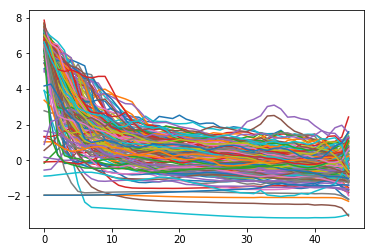

In [31]:
boxsize = 0.2
j=0

for j in range(171):
    data = data_tuple[0]; xsize = data.shape[0]; ysize = data.shape[1]
    minx,miny,maxx,maxy = xgal_10andup[j]-boxsize/2.,ygal_10andup[j]-boxsize/2.,xgal_10andup[j]+boxsize/2.,ygal_10andup[j]+boxsize/2.
    xystarts_tiny=[minx,miny]; size_tiny=[boxsize,boxsize] 
    data_tiny=data[minx*xsize/100.:maxx*xsize/100.,miny*ysize/100.:maxy*ysize/100.]

    center, radi = (data_tiny.shape[0]/2,data_tiny.shape[1]/2), 55
    rad = radial_profile(data_tiny, center)

    plt.plot(range(len(rad)),rad)
    
# label the axes

The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.490625 by 0.4875 (157 by 156 pixels)
The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.4875 by 0.490625 (156 by 157 pixels)
The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.490625 by 0.4875 (157 by 156 pixels)
The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.490625 by 0.4875 (157 by 156 pixels)
The size of the simulation box is 0.490625 by 0.490625 (157 by 157 pixels)
The size of the simulation box is 0.490625 by 0.490625 (157 by 157 pixels)
The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.4875 by 0.4875 (156 by 156 pixels)
The size of the simulation box is 0.4875 by 0.490625 (156 by 15

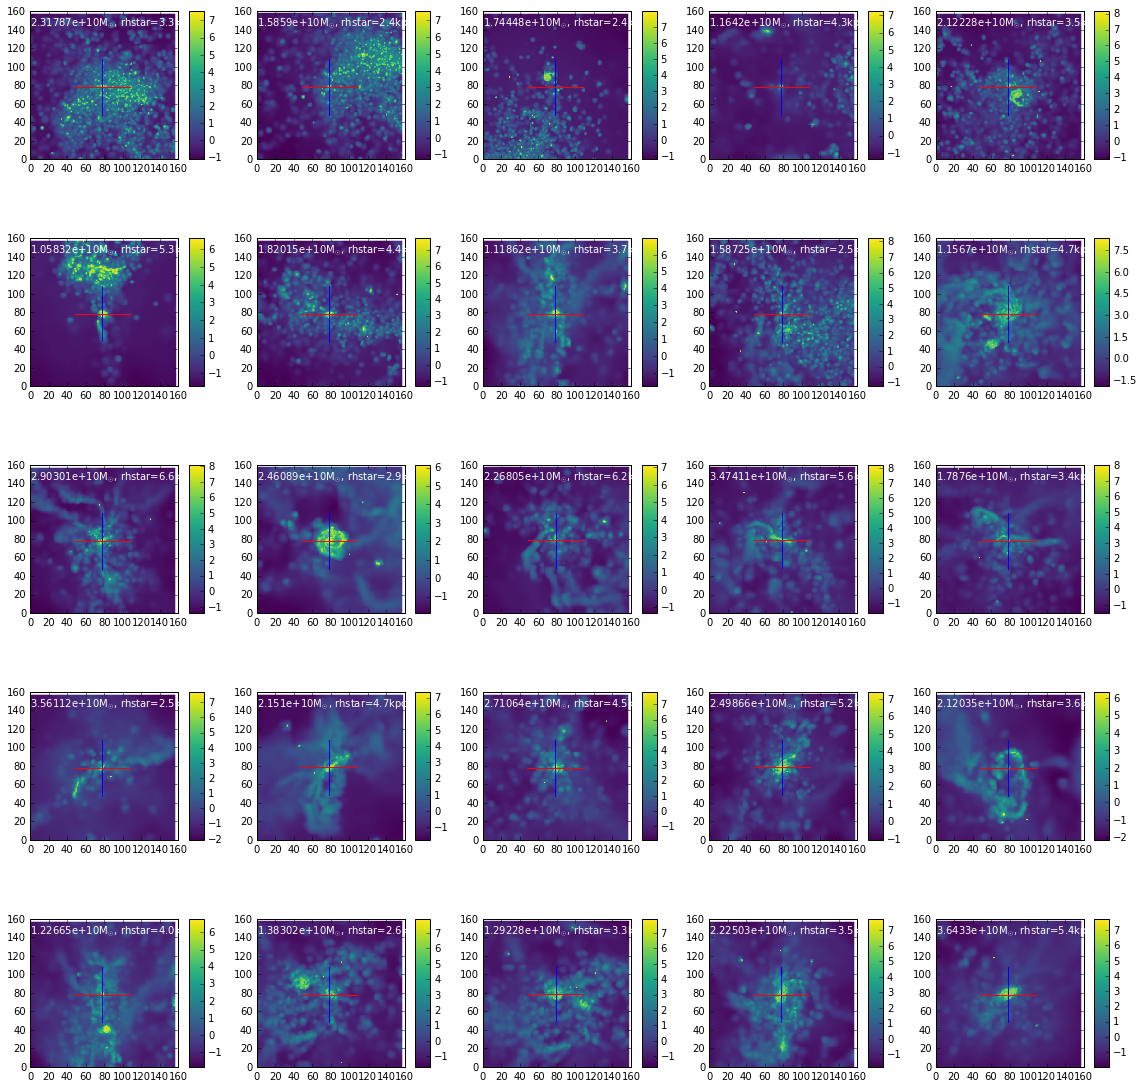

In [23]:
f, axarr = plt.subplots(5, 5,figsize=(16,16))
profiles_x = []
profiles_y = []
for j in range(25):
    data_tiny, xystarts_tiny, size_tiny = extractFOV(data_tuple,resolution,distance,\
                                                     x_center=xgal_10andup[j],y_center=ygal_10andup[j],\
                                                     x_angFOV=1000.,y_angFOV=1000.)
    
    plotdata(data_tiny.T,ax=axarr[j/5,j%5],colorbar=True,\
             label=r'%sM$_{\odot}$, rhstar=%.1fkpc'%(mgal_10andup[j],rhstar_10andup[j]))
   # pltimg(data_tiny,axarr[j/5,j%5],xystarts_tiny,size_tiny,\
   #        label=r'%sM$_{\odot}$, rhstar=%.1fkpc'%(mgal_10andup[j],rhstar_10andup[j]))
    

    xpixels = data_tiny.shape[0]
    ypixels = data_tiny.shape[1]
    print "The size of the simulation box is %s by %s (%s by %s pixels)"%(size_tiny[0],size_tiny[1],xpixels,ypixels)

    axarr[j/5,j%5].plot([xpixels/2.,xpixels/2.],      [ypixels/2.-30,ypixels/2.+30])
    axarr[j/5,j%5].plot([xpixels/2.-30,xpixels/2.+30],[ypixels/2.,ypixels/2.],color='red')

    profiles_x.append(data_tiny[xpixels/2.,ypixels/2.-30:ypixels/2.+30])
    profiles_y.append(data_tiny[xpixels/2.-30:xpixels/2.+30.,ypixels/2.])

   ## profile_needle279 = d_needle279[yval,xval-20:xval+20]
    
plt.tight_layout()


### Plot the Halpha profiles for some of these.

x:
skipped 1
skipped 19
y:
skipped 1


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in log10


[[  6.17018896e+03   3.89643320e+04  -3.27941445e+04]
 [  1.84042993e+03   6.22523633e+03  -4.38480664e+03]
 [  1.48440586e+04   5.05620859e+04  -3.57180273e+04]
 [  1.90918301e+04   8.41825234e+04  -6.50906953e+04]
 [  2.11334199e+04   5.63093242e+04  -3.51759062e+04]
 [  7.32832188e+04   2.19010812e+05  -1.45727594e+05]
 [  2.21910359e+05   7.41951688e+05  -5.20041312e+05]
 [  3.75225781e+05   6.09809125e+05  -2.34583344e+05]
 [  9.95926125e+05   1.60624038e+06  -6.10314250e+05]
 [  4.24472500e+06   6.11959450e+06  -1.87486950e+06]
 [  7.19918150e+06   7.73042950e+06  -5.31248000e+05]
 [  1.72703962e+06   2.24759700e+06  -5.20557375e+05]
 [  5.64967188e+05   1.09955112e+06  -5.34583938e+05]
 [  3.23435406e+05   7.48168000e+05  -4.24732594e+05]
 [  1.40762391e+05   3.14527938e+05  -1.73765547e+05]
 [  1.18713359e+05   3.52640188e+05  -2.33926828e+05]
 [  2.03332617e+04   5.94127969e+04  -3.90795352e+04]
 [  2.15825684e+04   9.44236875e+04  -7.28411172e+04]
 [  2.04925684e+04   7.70376

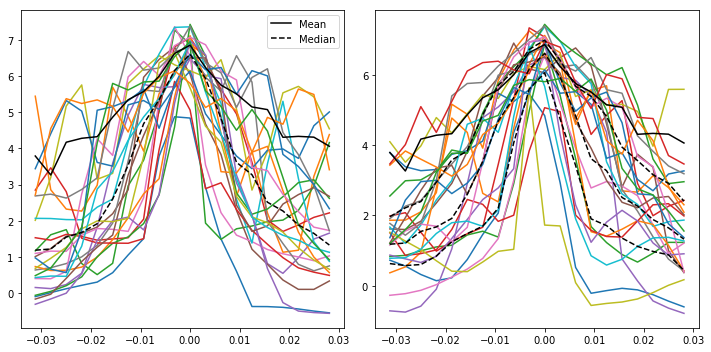

In [46]:
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))
profiles = np.array(profiles_x+profiles_y)

# normalize the profiles
normprofiles = [profile/np.max(profile) for profile in profiles]
# normalize the profiles
normprofiles = [profile - np.max(profile) for profile in profiles]
normprofiles_x = [profile - np.max(profile) for profile in profiles_x]
normprofiles_y = [profile - np.max(profile) for profile in profiles_y]

meanprofile = np.log10(np.mean(10**(profiles), axis=0))
medianprofile = np.log10(np.median(10**(profiles), axis=0))
sigmaprofile = np.log10(np.std(10**(profiles), axis=0))
p25profile = np.percentile(profiles, 25, axis=0)
p75profile = np.percentile(profiles, 75, axis=0)

totallength = 0.4875 * (20./156.) #0.4875 by 0.490625 (156 by 157 pixels)
xvalues = np.arange(totallength/-2.,totallength/2.,totallength/len(meanprofile[20:40]))
ax1.set_xlabel('Mpc')

countx = 1
print "x:"
for profile in profiles_x:
    if max(profile) < 4:
        print 'skipped %s'%countx
        continue
    ax1.plot(xvalues,(profile[20:40]))
    countx+=1
county = 1
print "y:"
for profile in profiles_y:
    if max(profile) < 4:
        print 'skipped %s'%county
        continue
    ax2.plot(xvalues,(profile[20:40]))
    county+=1

ax1.plot(xvalues,meanprofile[20:40],color='black',label='Mean')
ax1.plot(xvalues,medianprofile[20:40],color='black',linestyle='--',label='Median')

ax2.plot(xvalues,meanprofile[20:40],color='black')
ax2.plot(xvalues,medianprofile[20:40],color='black',linestyle='--')
ax2.plot(xvalues,p25profile[20:40],color='black',linestyle='--')
ax2.plot(xvalues,p75profile[20:40],color='black',linestyle='--')

lowerr = np.log10( 10**meanprofile[20:40] - 10**sigmaprofile[20:40] ) 
print np.array([10**meanprofile[20:40],(10**sigmaprofile[20:40]),10**meanprofile[20:40] - 10**sigmaprofile[20:40]]).T
print lowerr
lowerr[np.isnan(lowerr)] = 0 # set where sigma drops below zero to zero, since in log space this is NaNs
higherr = np.log10( 10**meanprofile[20:40] + 10**sigmaprofile[20:40] ) 

#ax2.plot(xvalues,lowerr,color='black',linestyle='--')
#ax2.plot(xvalues,higherr,color='black',linestyle='--')

print meanprofile
print sigmaprofile
#ax1.fill_between(np.arange(len(medianprofile[20:40])), lowerr, y1)

ax1.legend()
plt.tight_layout()

### Same as above, but normalized

TypeError: only integer arrays with one element can be converted to an index

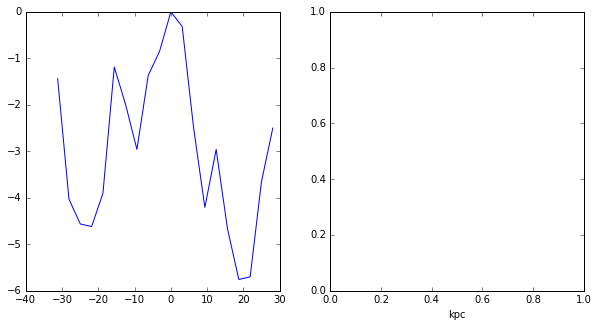

In [28]:
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))
profiles = np.array(profiles_x+profiles_y)

# normalize the profiles
normprofiles = [profile/np.max(profile) for profile in profiles]
# normalize the profiles
normprofiles = [profile - np.max(profile) for profile in profiles]
normprofiles_x = [profile - np.max(profile) for profile in profiles_x]
normprofiles_y = [profile - np.max(profile) for profile in profiles_y]
normprofiles = np.array(normprofiles)

meanprofile = np.log10(np.mean(10**(normprofiles), axis=0))
medianprofile = np.log10(np.median(10**(normprofiles), axis=0))
sigmaprofile = np.log10(np.std(10**(normprofiles), axis=0))
p25profile = np.percentile(normprofiles, 25, axis=0)
p75profile = np.percentile(normprofiles, 75, axis=0)

totallength = 0.4875 * (20./156.) #0.4875 by 0.490625 (156 by 157 pixels)
xvalues = np.arange(totallength/-2.,totallength/2.,totallength/len(meanprofile[20:40]))*1000.
ax2.set_xlabel('kpc')
ax2.set_xlabel('kpc')

# try to find a way to sort the profiles - ratio of max value to average at some distance from the center
ratio_x = []
ratio_y = []

countx = 1
#print "x:"
for profile in normprofiles_x:
    ax1.plot(xvalues,(profile[20:40]))
    ratio_x.append(np.max(profile[20:40])/np.mean(profile[24:26],profile[34:36]))
    countx+=1
county = 1
#print "y:"
for profile in normprofiles_y:
    ax2.plot(xvalues,(profile[20:40]))
    ratio_y.append(np.max(profile[20:40])/np.mean(profile[24:26],profile[34:36]))
    county+=1

ax1.plot(xvalues,meanprofile[20:40],color='black',label='Mean')
ax1.plot(xvalues,medianprofile[20:40],color='black',linestyle='--',label='Median')

ax2.plot(xvalues,meanprofile[20:40],color='black')
ax2.plot(xvalues,medianprofile[20:40],color='blue',linestyle='--')
ax2.plot(xvalues,p25profile[20:40],color='blue',linestyle='--')
ax2.plot(xvalues,p75profile[20:40],color='blue',linestyle='--')

lowerr = np.log10( 10**meanprofile[20:40] - (10**sigmaprofile[20:40])/5 ) 
#print np.array([10**meanprofile[20:40],(10**sigmaprofile[20:40]),10**meanprofile[20:40] - (10**sigmaprofile[20:40])/5]).T
#print lowerr
#lowerr[np.isnan(lowerr)] = -8 # set where sigma drops below zero to zero, since in log space this is NaNs
higherr = np.log10( 10**meanprofile[20:40] + 10**sigmaprofile[20:40] ) 

ax2.plot(xvalues,lowerr,color='black',linestyle='--')
ax2.plot(xvalues,higherr,color='black',linestyle='--')

#print meanprofile
#print sigmaprofile
#ax1.fill_between(np.arange(len(medianprofile[20:40])), lowerr, y1)

ax1.legend()
plt.tight_layout()

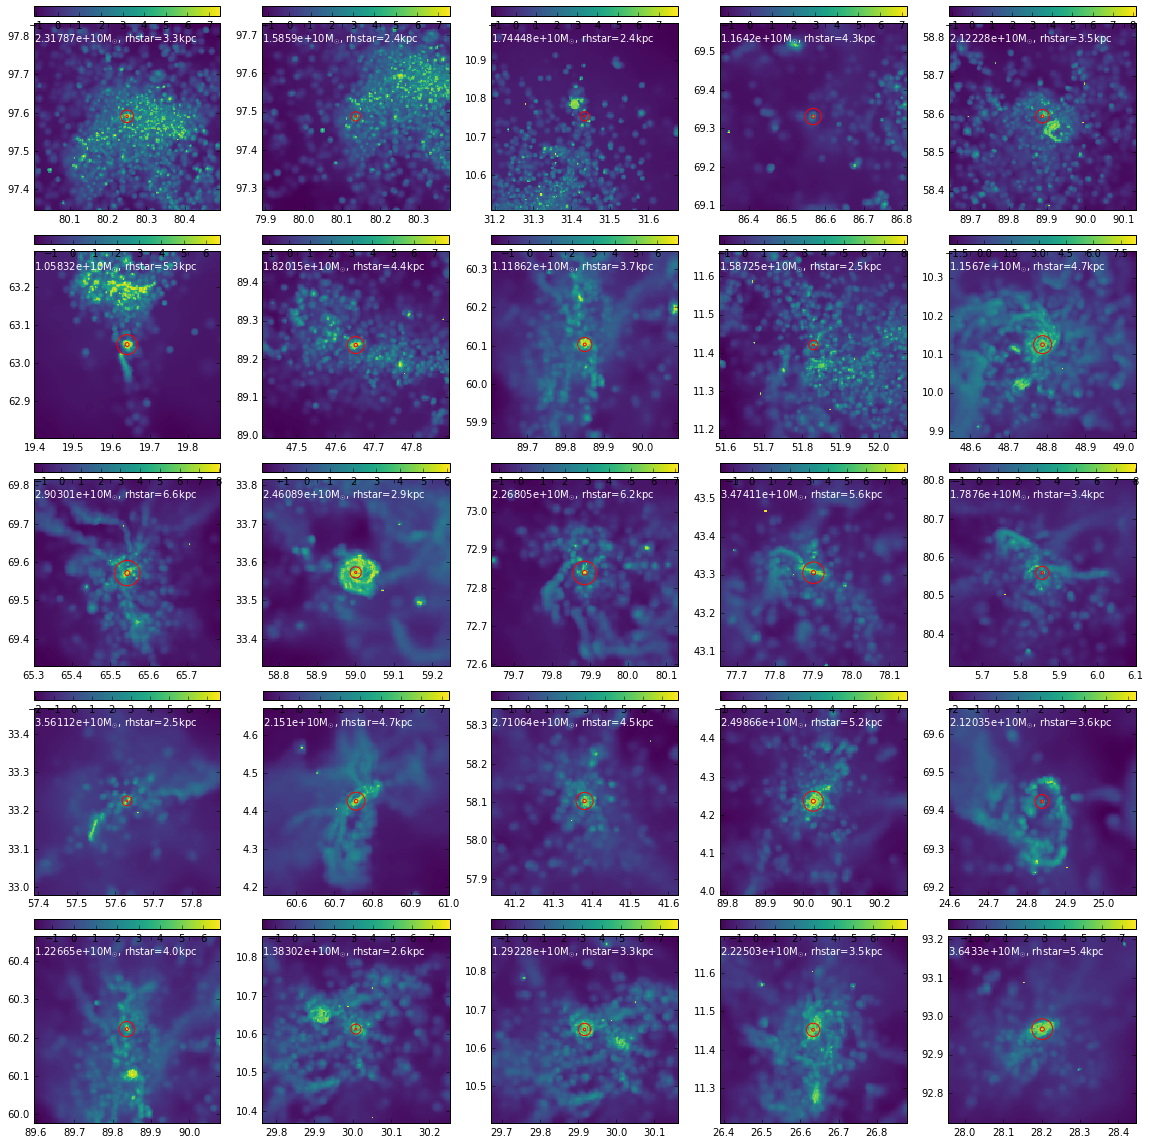

In [20]:
f, axarr = plt.subplots(5, 5,figsize=(16,16))
profiles = []
for j in range(25):
    data_tiny, xystarts_tiny, size_tiny = extractFOV(data_tuple,resolution,distance,\
                                                     x_center=xgal_10andup[j],y_center=ygal_10andup[j],\
                                                     x_angFOV=1000.,y_angFOV=1000.)
    pltimg(data_tiny,axarr[j/5,j%5],xystarts_tiny,size_tiny,\
           label=r'%sM$_{\odot}$, rhstar=%.1fkpc'%(mgal_10andup[j],rhstar_10andup[j]))
    
    circle1 = plt.Circle((xgal_10andup[j],ygal_10andup[j]), radius=rhstar_10andup[j]/1000., color='red',fill=False)
    axarr[j/5,j%5].add_artist(circle1)
    
    circle1 = plt.Circle((xgal_10andup[j],ygal_10andup[j]), radius=rhstar_10andup[j]/1000.*5., color='red',fill=False)
    axarr[j/5,j%5].add_artist(circle1)
    
   # axarr[j/5,j%5].plot([size_tiny[0]/2.+xystarts_tiny[0],size_tiny[1]/2.+xystarts_tiny[0]],\
   #                     [size_tiny[0]/2.-0.2+xystarts_tiny[1],size_tiny[1]/2.+0.2+xystarts_tiny[1]])
   # axarr[j/5,j%5].plot([size_tiny[0]/2.-0.2+xystarts_tiny[0],size_tiny[1]/2.+0.2+xystarts_tiny[0]],\
   #                     [size_tiny[0]/2.+xystarts_tiny[1],size_tiny[1]/2.+xystarts_tiny[1]],color='red')
   # xpixels = data_tiny.shape[0]
   # ypixels = data_tiny.shape[1]
    #print xpixels,ypixels
    #print data_tiny.shape
    #profiles.append(size_tiny/2,size_tiny/2)
plt.tight_layout()

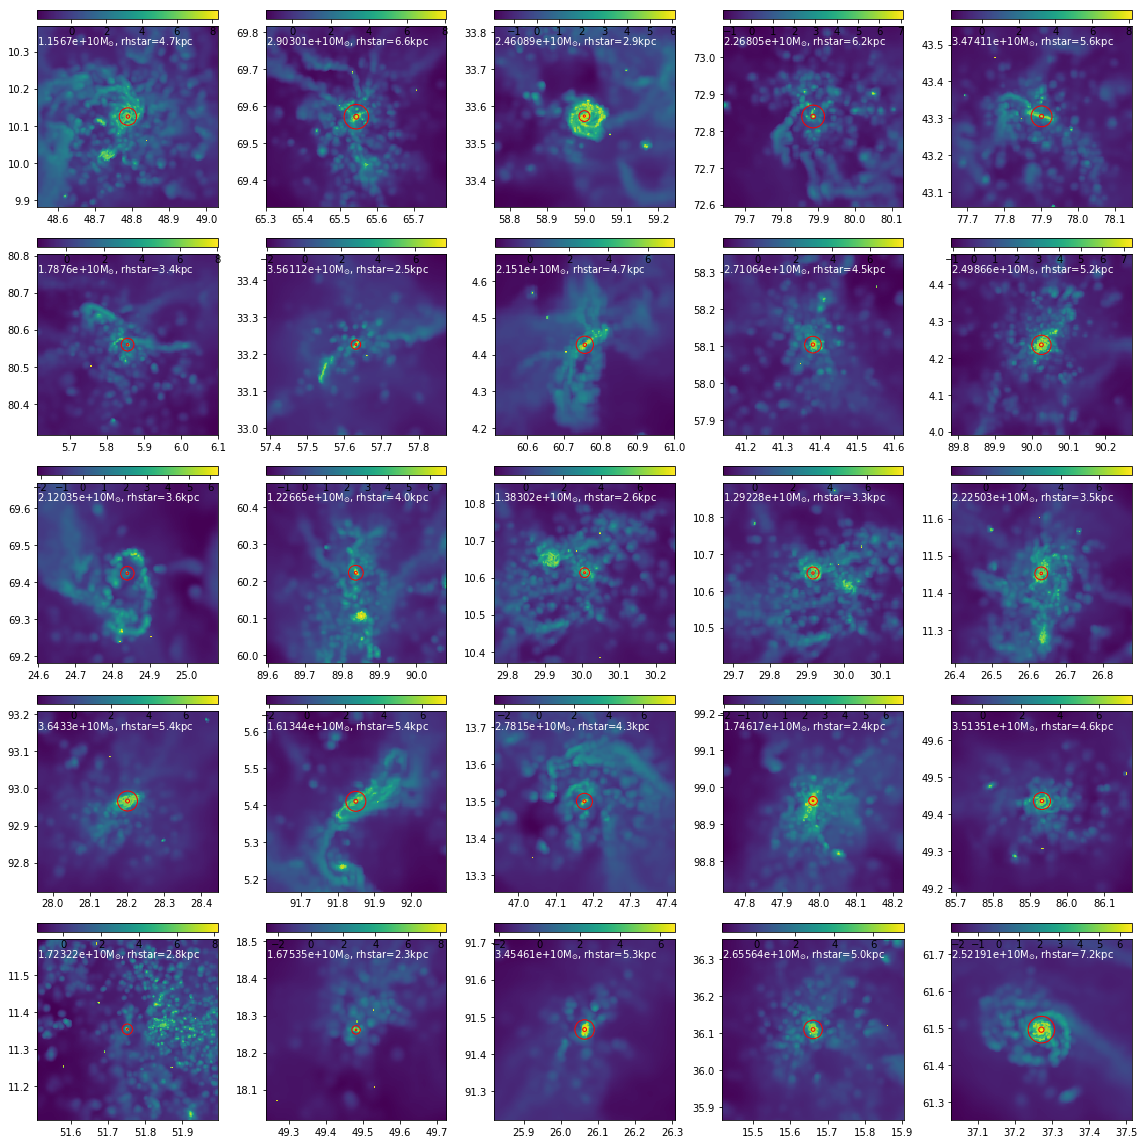

In [34]:
f, axarr = plt.subplots(5, 5,figsize=(16,16))
for j in range(25,50):
    i = j-25
    data_tiny, xystarts_tiny, size_tiny = extractFOV(data_tuple,resolution,distance,\
                                                     x_center=xgal_10andup[j],y_center=ygal_10andup[j],\
                                                     x_angFOV=1000.,y_angFOV=1000.)
    pltimg(data_tiny,axarr[i/5,i%5],xystarts_tiny,size_tiny,\
           label=r'%sM$_{\odot}$, rhstar=%.1fkpc'%(mgal_10andup[j],rhstar_10andup[j]))
    circle1 = plt.Circle((xgal_10andup[j],ygal_10andup[j]), radius=rhstar_10andup[j]/1000., color='red',fill=False)
    axarr[i/5,i%5].add_artist(circle1)
    
    circle1 = plt.Circle((xgal_10andup[j],ygal_10andup[j]), radius=rhstar_10andup[j]/1000.*5., color='red',fill=False)
    axarr[i/5,i%5].add_artist(circle1)
plt.tight_layout()

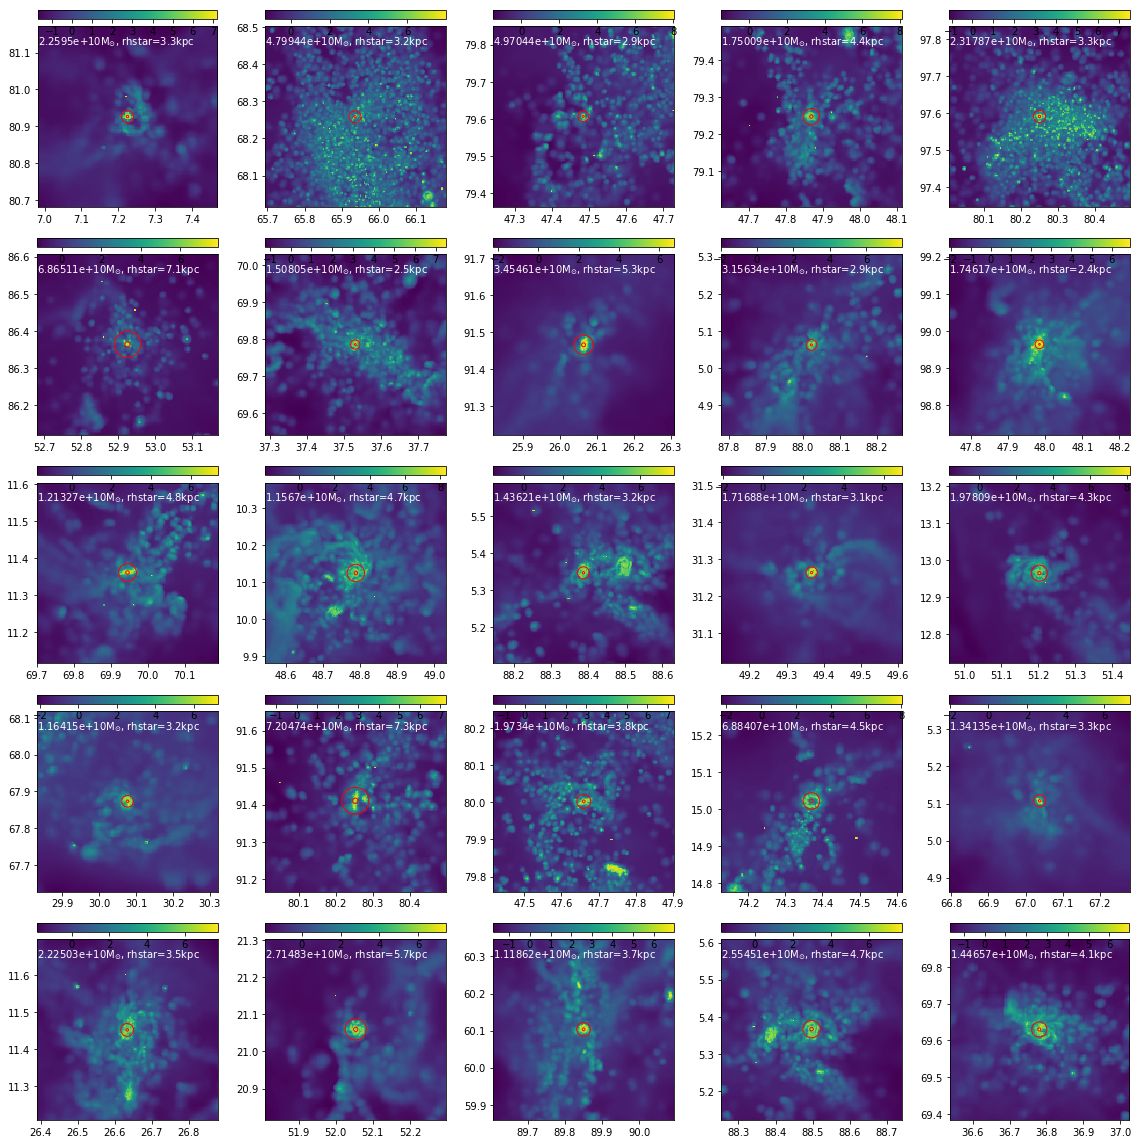

In [23]:
f, axarr = plt.subplots(5, 5,figsize=(16,16))
for j in range(50,75):
    i = j-50
    data_tiny, xystarts_tiny, size_tiny = extractFOV(data_tuple,resolution,distance,\
                                                     x_center=xgal_10andup[j],y_center=ygal_10andup[j],\
                                                     x_angFOV=1000.,y_angFOV=1000.)
    pltimg(data_tiny,axarr[i/5,i%5],xystarts_tiny,size_tiny,\
           label=r'%sM$_{\odot}$, rhstar=%.1fkpc'%(mgal_10andup[j],rhstar_10andup[j]))
    circle1 = plt.Circle((xgal_10andup[j],ygal_10andup[j]), radius=rhstar_10andup[j]/1000., color='red',fill=False)
    axarr[i/5,i%5].add_artist(circle1)
    
    circle1 = plt.Circle((xgal_10andup[j],ygal_10andup[j]), radius=rhstar_10andup[j]/1000.*5., color='red',fill=False)
    axarr[i/5,i%5].add_artist(circle1)
plt.tight_layout()

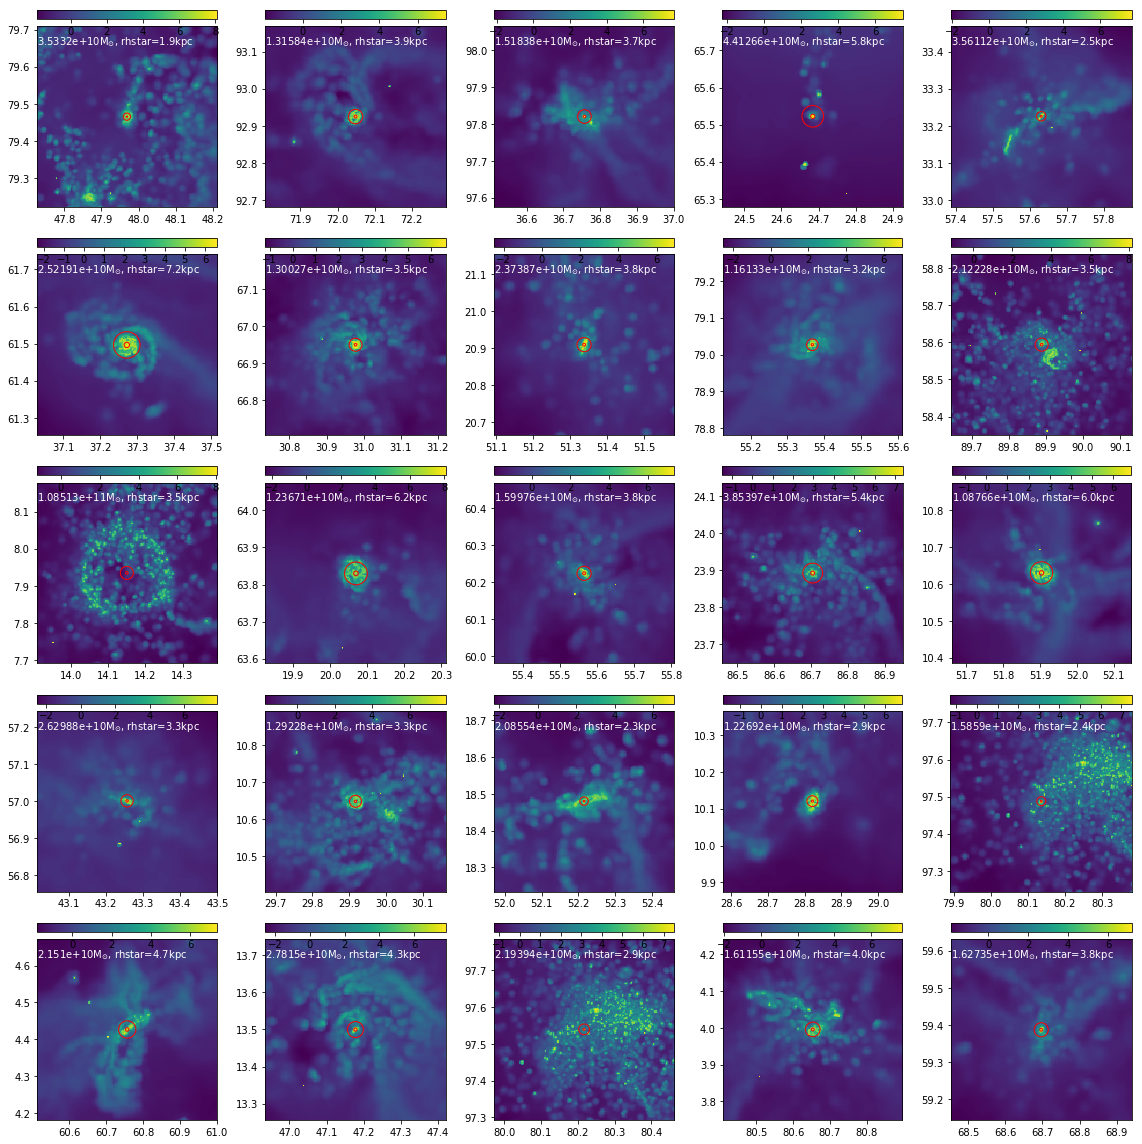

In [24]:
f, axarr = plt.subplots(5, 5,figsize=(16,16))
for j in range(75,100):
    i = j-75
    data_tiny, xystarts_tiny, size_tiny = extractFOV(data_tuple,resolution,distance,\
                                                     x_center=xgal_10andup[j],y_center=ygal_10andup[j],\
                                                     x_angFOV=1000.,y_angFOV=1000.)
    pltimg(data_tiny,axarr[i/5,i%5],xystarts_tiny,size_tiny,\
           label=r'%sM$_{\odot}$, rhstar=%.1fkpc'%(mgal_10andup[j],rhstar_10andup[j]))
    circle1 = plt.Circle((xgal_10andup[j],ygal_10andup[j]), radius=rhstar_10andup[j]/1000., color='red',fill=False)
    axarr[i/5,i%5].add_artist(circle1)
    
    circle1 = plt.Circle((xgal_10andup[j],ygal_10andup[j]), radius=rhstar_10andup[j]/1000.*5., color='red',fill=False)
    axarr[i/5,i%5].add_artist(circle1)
plt.tight_layout()